<a href="https://colab.research.google.com/github/p25-c4/kurly_project/blob/main/0320_SG_DATA_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Mar 20 11:28:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq
# !rm ~/.cache/matplotlib -rf

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 한글폰트 설정
mpl.rc("font",family = "NanumGothic")
mpl.rc("axes", unicode_minus = False)

# Data load

In [4]:
import os
os.chdir("/content/drive/MyDrive/BigData/early_project")

In [5]:
items = pd.read_csv("on_items.csv")  # 상품 data
orders = pd.read_csv("on_orders.csv")  # 주문 data
users = pd.read_csv("on_users.csv",encoding='cp949')  # 고객 data

## items의 소분류 품목 이름 변경
    - e.g. '토마' --> '토마토'

In [6]:
items.head()

,ItemLargeCode,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemCode,ItemName,PriceYear,PriceMin,PriceMax
0,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1001,(식품)샘표 김치국수 101g 10입(가공식품),2021,15840,16130
1,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1001,(식품)샘표 김치국수 101g 10입(가공식품),2022,17030,17340
2,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1001,(식품)샘표 김치국수 101g 10입(가공식품),2023,17380,18640
3,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1002,2.1kg 6배 메밀 Bestco 희석용 소바 국수장국,2022,14160,15350
4,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1002,2.1kg 6배 메밀 Bestco 희석용 소바 국수장국,2023,15060,16160


In [7]:
items['ItemSmallName'] = items['ItemSmallName'].replace({'토마':'토마토','드레':'드레싱','오징':'오징어','파프':'파프리카',
                                                        '아몬':'아몬드','고구':'고구마','고등':'고등어','소시':'소시지',
                                                        '풋고':'풋고추','파스':'파스타','닭고':'닭고기','블루':'블루베리',
                                                        '콩나':'콩나물','고사':'고사리','쇠고':'쇠고기'})

## orders 에 Delay_YN 열 추가

In [8]:
## 오전 7시 이후 배송을 Delay로 처리
# OrderDT와 DeliveryDT 타입 변경
orders['OrderDT'] = pd.to_datetime(orders['OrderDT'], format='%d%b%Y:%H:%M:%S')
orders['DeliveryDT'] = pd.to_datetime(orders['DeliveryDT'], format='%d%b%Y:%H:%M:%S')
# DeliveryDT가 오전 7시보다 늦으면 'Y', 이전이면 'N'인 파생 변수 생성
orders['Delay_YN'] = orders['DeliveryDT'].dt.hour >= 7
orders['Delay_YN'] = orders['Delay_YN'].map({True: 1, False: 0}) # 지연: 1, 지연X: 0

orders.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0


In [9]:
## Delay로 처리한 것 중 예외처리
# DeliveryDT가 오전 7시보다 늦으면 'Y', 이전이면 'N'인 파생 변수 생성
orders['OrderDT'] = pd.to_datetime(orders['OrderDT'], format='%Y-%m-%d %H:%M:%S')
orders['DeliveryDT'] = pd.to_datetime(orders['DeliveryDT'], format='%Y-%m-%d %H:%M:%S')
# DeliveryDT와 OrderDT 사이의 일수 차이 계산
orders['Day_Diff'] = (orders['DeliveryDT'] - orders['OrderDT']).dt.days
# 조건에 맞는 행을 필터링하여 Delay_YN 업데이트
# 조건: 원래 Delay_YN 값이 1이며, DeliveryDT의 시간이 7시 이상, OrderDT의 시간이 21시 이상, Day_Diff가 정확히 1일인 경우
orders.loc[(orders['Delay_YN'] == 1) & (orders['DeliveryDT'].dt.hour >= 7) & (orders['OrderDT'].dt.hour >= 21) & (orders['Day_Diff'] == 0), 'Delay_YN'] = 0
# 더 이상 필요 없는 Day_Diff 칼럼 삭제
orders.drop('Day_Diff', axis=1, inplace=True)

## users에 Agegroup 추가

In [10]:
## users에 Agegroup 추가
# Age 열을 기준으로 2030/4060
bins = [19,39,69]  # 연령대 경계값
labels = ['2030s','4060s']  # 각 연령대에 해당하는 라벨
users['AgeGroup'] = pd.cut(users['Age'], bins=bins, labels=labels, right=True)

In [11]:
# AgeGroup object로 변경
users['AgeGroup'] = users['AgeGroup'].astype("object")
users['AgeGroup']

0       2030s
1       4060s
2       2030s
3       2030s
4       2030s
        ...  
2995    4060s
2996    2030s
2997    2030s
2998    2030s
2999    2030s
Name: AgeGroup, Length: 3000, dtype: object

# DataFrame 합치기

In [12]:
print(users.shape, items.shape, orders.shape)

(3000, 6) (11019, 11) (1043272, 7)


In [13]:
# orders + items
items_NoPrice = items.iloc[:,:-3]  # 중복 제거를 위해 items에서 Price 관련 변수들 제거
order_item = pd.merge(orders, items_NoPrice, on='ItemCode', how='left') # orders + items
order_item = order_item.drop_duplicates(ignore_index= True) # 중복행 제거
order_item.shape

(1043272, 14)

In [14]:
order_user_item = pd.merge(order_item, users, on='idUser', how='left') # order_item + users
order_user_item.shape

(1043272, 19)

In [15]:
order_user_item.isnull().sum()

idUser            0
idOrder           0
OrderDT           0
ItemCode          0
Price             0
DeliveryDT        0
Delay_YN          0
ItemLargeCode     0
ItemLargeName     0
ItemMiddleCode    0
ItemMiddleName    0
ItemSmallCode     0
ItemSmallName     0
ItemName          0
Gender            0
Age               0
FamilyCount       0
MemberYN          0
AgeGroup          0
dtype: int64

## not_food 처리

In [16]:
# list of not food --> 시간 오래 걸렸음
not_food = ["냄비", "기계", "디스펜서", "퍼즐", "냉장고", "밀폐용기",
            "액자", "수동 반죽펴기", "채칼", "캔따기", "모자",
            "카지노","용기","케이스","만두통", "바람개비", "레깅스", "수박 나무라고요",
            "스텐 상추바구니 2호 야채 튀김 과일 바스켓 채반",
            "스테인레스 상추바구니 1호 메쉬바구니 소쿠리 채반",
            "스텐 타공상추바구니 2호","수박과도 大 (10개묶음) 0151","양상추 1cm 샌들 슬리퍼  JG6 (7157830)",
            "후르츠커버포켓크로스백(수박)", "양상추 여름 블라우스 JAP60 (7271217)", "양상추 여자 슬랙스 BF33 (7416269)",
            "양상추 여자 여름샌들 JK131 (7162818)", "MT124 A4 참외색 매직터치 두성 180g 10매입 X ( 3세트 )",
            "에이프릴래빗 양상추 스트링 빅포켓 숏야상점퍼 MA0906 (6660376)", "사랑에 빠진 과일토퍼 - 참외",
            "[총알배송] 제오닉 화채 수박통 8L 채반 믹싱볼 샐러드볼 판촉물 답례품 사은",
            "익사이팅 컬러링토이 유화물감 스포츠 스포츠 참외",
            "[하프클럽/한샘]SOK 프레시 여름 사각 수박용기 4L 2P",
            "참외 모형 1P (소)", "양상추키우기 7종", "양상추키우기 7종 채소키우기", "나 채소",
            "초 가을 계절 개성 캐쥬얼 참외 껍질 쿨링 여성", "22511712S3488857739", "타공 상추 바구니 2호 과일채소 씻어 빠른건조 주방",
            "OBSESSION 100g150g200g250g300g Kabura Bullet 금속 지그 헤드 오징어 어시", "나혼자키운다(대파)",
            "밀폐용기 42호 3L 2P세트 수박보관통 과일 대파 냉장고수납 야채 냉동실정리", "양파 대파 감자 마늘 생강 조개 과일망 메시 메쉬 그물망 일자형",
            "기타보관용기 지혜 냉동만두 수납함 다층 물만두 전용", "냉장고박스 Shujiabao.만두케이스 냉동만두 다층", "(5개묶음)까기쉬운 삼덕 밤가위 색상랜덤발송 밤까기",
            "낮과 밤을 만들어요 5명 set", "달의 위상과 지구의 낮과 밤 5인용", "반고흐 패브릭 포스터 별이빛나는밤 M", "밤깍는 생활 생밤칼 주방","별이 빛나는 밤에 반지 폭3mm 전체925실버",
            "별이 빛나는 밤에 반지 폭3mm 전체925실버", "코르크메모지 액자(산타는 밤에 와요) 5인용 집콕놀이", "통조림 캔따개 황도 참치 꽁치 따개 캔 오프너 업소용",
            "황도12궁풀러렌축구공 10인용", "그린 고사리 부쉬 조화", "그린 고사리설악초 페이퍼바스켓세트 조화 실크플라워", "인조나무 인테리어 조화 화분 솔향고사리 2P SET",
            "기타보관용기 만두통 냉동만두 가정용 급속냉동", "냉장고박스 만두케이스 계란 신선보존 훈툰만두 냉동",
            "냉장고박스 만두케이스 냉동만두 가정용 급속냉동", "냉장고박스 만두케이스 냉동만두 다층 가정용 급속냉동 혼돈",
            "쟁반 급속냉동 반달형 물만두 수납함 냉동만두", "정리함 만두통 냉동만두 전용 물만두 받침판 냉장고","초대형 물고기 미끼 20cm 80g 대형 포퍼 지깅 도구 저크 베이트 낚시 루어 태",
            "뇨끼판 뇨끼 보드 파스타 반죽 국수 면 만드는 도구", "클레어 파스타집게 다용도 샐러드 면요리용 조리도구"
            ]
len(not_food)

68

In [17]:
# ItemName에 not_food의 값이 포함된 경우 추출
not_food_order_item = order_user_item[order_user_item['ItemName'].apply(lambda x: any(item for item in not_food if item in x))]
print(not_food_order_item.shape)
not_food_order_item.head()

(24561, 19)


,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemName,Gender,Age,FamilyCount,MemberYN,AgeGroup
103,U10001,U10001-O2021-1021,2021-09-11 08:18:12,L4-M12-S0430-1008,1320,2021-09-13 05:56:00,0,L4,신선식품,M12,과일,S0430,수박,DIY614 수박바람개비만들기,여성,26,2,Y,2030s
107,U10001,U10001-O2021-1022,2021-08-31 17:06:38,L1-M15-S0140-1357,26770,2021-09-01 06:36:00,0,L1,가공식품,M15,냉동,S0140,냉동,쟁반 급속냉동 반달형 물만두 수납함 냉동만두,여성,26,2,Y,2030s
186,U10001,U10001-O2022-1009,2022-09-28 18:40:30,L4-M12-S0560-1016,13780,2022-09-29 05:41:00,0,L4,신선식품,M12,과일,S0560,참외,초 가을 계절 개성 캐쥬얼 참외 껍질 쿨링 여성 22511712S3488857739,여성,26,2,Y,2030s
284,U10001,U10001-O2023-1003,2023-11-29 19:40:33,L1-M11-S0280-1051,26940,2023-11-30 06:58:00,0,L1,가공식품,M11,곡물,S0280,밤,낮과 밤을 만들어요 5명 set,여성,26,2,Y,2030s
295,U10001,U10001-O2023-1004,2023-12-06 15:25:42,L4-M12-S0430-1013,22900,2023-12-07 06:32:00,0,L4,신선식품,M12,과일,S0430,수박,[하프클럽/한샘]SOK 프레시 여름 사각 수박용기 4L 2P,여성,26,2,Y,2030s


    - 총 24561 개(총 주문 데이터의 약 2%)
    - 분석 대상이 아님 --> 제외

In [18]:
# items 에서 not_food 제거
order_user_item = order_user_item.drop(index = not_food_order_item.index)

## Datetime 추가

In [19]:
order_user_item['Date'] = order_user_item['OrderDT'].dt.strftime('%Y-%m-%d')

## Year, Month, Day, Hour 추가

In [20]:
# OrderDT 열을 datetime 객체로 변환
order_user_item['OrderDT'] = pd.to_datetime(order_user_item['OrderDT'], format='%d%b%Y:%H:%M:%S')

# datetime 객체에서 년을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Year'] = order_user_item['OrderDT'].dt.year
# datetime 객체에서 월을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Month'] = order_user_item['OrderDT'].dt.month
# datetime 객체에서 일을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Day'] = order_user_item['OrderDT'].dt.day
# datetime 객체에서 시를 추출하여 새로운 컬럼 Month에 저장
order_user_item['Hour'] = order_user_item['OrderDT'].dt.hour
order_user_item.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Gender,Age,FamilyCount,MemberYN,AgeGroup,Date,Year,Month,Day,Hour
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,여성,26,2,Y,2030s,2021-12-03,2021,12,3,20
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,여성,26,2,Y,2030s,2021-12-03,2021,12,3,20
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,여성,26,2,Y,2030s,2021-12-03,2021,12,3,20
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,여성,26,2,Y,2030s,2021-12-03,2021,12,3,20
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,여성,26,2,Y,2030s,2021-12-03,2021,12,3,20


## ItemName list col 생성

In [21]:
# ItemName 소문자로 변경
order_user_item['ItemName'] = order_user_item['ItemName'].apply(lambda x: x.lower())

In [22]:
import re

# 불용문자 목록
stop_words = ["&amp;", "&times;"]

# 불용어와 특수문자를 처리한 데이터를 데이터프레임에 새로운 열로 추가
order_user_item['CleanedItemName'] = order_user_item['ItemName'].apply(lambda name: re.sub(r"[?)(\[-\]-/~_:<>=#]",' ',name))
order_user_item['CleanedItemName'] = order_user_item['CleanedItemName'].apply(lambda name: re.sub('|'.join(map(re.escape, stop_words)), ' ', name))
order_user_item.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Age,FamilyCount,MemberYN,AgeGroup,Date,Year,Month,Day,Hour,CleanedItemName
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,26,2,Y,2030s,2021-12-03,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,26,2,Y,2030s,2021-12-03,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,26,2,Y,2030s,2021-12-03,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,26,2,Y,2030s,2021-12-03,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,26,2,Y,2030s,2021-12-03,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공


## 재주문 간격

In [23]:
# 데이터프레임 이름이 order_user라고 가정하고 수정
order_user_item['OrderDT'] = pd.to_datetime(order_user_item['OrderDT'])  # OrderDT를 datetime 타입으로 변환

# 데이터프레임을 idUser, ItemCode, OrderDT 기준으로 정렬
order_user_sorted = order_user_item.sort_values(by=['idUser', 'OrderDT'])

# idUser와 ItemCode 별로 그룹화한 후, OrderDT 열의 차이(diff)를 계산하여 새로운 열에 저장
order_user_sorted['TimeBetweenOrders'] = order_user_sorted.copy().groupby(['idUser'])['OrderDT'].diff()

# 첫 번째 주문을 제외하고 싶다면, NaN 값이 있는 행을 제거
# repeat_order_periods = order_user_sorted.dropna(subset=['TimeBetweenOrders'])

order_user_sorted.head(100)

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,FamilyCount,MemberYN,AgeGroup,Date,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders
7,U10001,U10001-O2021-1002,2021-01-07 17:08:51,L1-M15-S0140-1323,22520,2021-01-08 06:24:00,0,L1,가공식품,M15,...,2,Y,2030s,2021-01-07,2021,1,7,17,오뚜기 듬뿍 새우볶음밥450g 2인분 x 5봉지,NaT
8,U10001,U10001-O2021-1002,2021-01-07 17:08:51,L1-M21-S0540-1082,3780,2021-01-08 06:24:00,0,L1,가공식품,M21,...,2,Y,2030s,2021-01-07,2021,1,7,17,동원 양반 차돌된장찌개 460g,0 days 00:00:00
9,U10001,U10001-O2021-1002,2021-01-07 17:08:51,L4-M12-S0350-1036,21630,2021-01-08 06:24:00,0,L4,신선식품,M12,...,2,Y,2030s,2021-01-07,2021,1,7,17,산지직송 새콤달콤 부사 사과 5kg 13과내,0 days 00:00:00
10,U10001,U10001-O2021-1002,2021-01-07 17:08:51,L4-M17-S0530-1026,33310,2021-01-08 06:24:00,0,L4,신선식품,M17,...,2,Y,2030s,2021-01-07,2021,1,7,17,완도 활전복 1kg 중 22 25미,0 days 00:00:00
11,U10001,U10001-O2021-1003,2021-01-14 16:50:14,L1-M11-S0220-1033,3950,2021-01-15 06:28:00,0,L1,가공식품,M11,...,2,Y,2030s,2021-01-14,2021,1,14,16,농심 봉지라면 멀티팩 골라담기 농심 신라면 5개입 1팩,6 days 23:41:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,U10001,U10001-O2021-1022,2021-08-31 17:06:38,L4-M17-S0130-1040,23380,2021-09-01 06:36:00,0,L4,신선식품,M17,...,2,Y,2030s,2021-08-31,2021,8,31,17,프라임 냉동낙지 3kg 2.5kg 활낙지 냉동 제품,0 days 00:00:00
110,U10001,U10001-O2021-1022,2021-08-31 17:06:38,L4-M17-S0810-1001,10140,2021-09-01 06:36:00,0,L4,신선식품,M17,...,2,Y,2030s,2021-08-31,2021,8,31,17,법성포참맛 더 커진 프리미엄 영광굴비 100g,0 days 00:00:00
111,U10001,U10001-O2021-1022,2021-08-31 17:06:38,L4-M22-S0360-1007,12630,2021-09-01 06:36:00,0,L4,신선식품,M22,...,2,Y,2030s,2021-08-31,2021,8,31,17,자연맛남 자연농원 유기농 적상추 1kg,0 days 00:00:00
112,U10001,U10001-O2021-1023,2021-09-07 18:25:16,L1-M15-S0140-1413,4820,2021-09-08 05:13:00,0,L1,가공식품,M15,...,2,Y,2030s,2021-09-07,2021,9,7,18,해태제과 얇은피 고향만두 800g+150g 950g,7 days 01:18:38


In [24]:
# 결과 확인
orders_for_merge = order_user_sorted[['idOrder','OrderDT', 'TimeBetweenOrders']]
orders_for_merge = orders_for_merge.drop_duplicates(subset='idOrder', keep='first')

In [25]:
# 병합
order_user_item = pd.merge(order_user_item, orders_for_merge, on=['idOrder','OrderDT'], how='left')

In [26]:
order_user_item[:100]

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,FamilyCount,MemberYN,AgeGroup,Date,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,2,Y,2030s,2021-12-03,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,2,Y,2030s,2021-12-03,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,2,Y,2030s,2021-12-03,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,2,Y,2030s,2021-12-03,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,2,Y,2030s,2021-12-03,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L1-M19-S0190-1003,3380,2021-06-07 06:38:00,0,L1,가공식품,M19,...,2,Y,2030s,2021-06-06,2021,6,6,14,당일발송 추천오뚜기 1000아일랜드드레싱250g,6 days 21:17:50
96,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L4-M18-S0110-1084,18330,2021-06-07 06:38:00,0,L4,신선식품,M18,...,2,Y,2030s,2021-06-06,2021,6,6,14,하선정 하선정 시원한포기김치 5kg,6 days 21:17:50
97,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L4-M22-S0170-1031,17840,2021-06-07 06:38:00,0,L4,신선식품,M22,...,2,Y,2030s,2021-06-06,2021,6,6,14,말린 도라지 길경 1kg 도라지차 요리 육수 중국산,6 days 21:17:50
98,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L4-M22-S0700-1064,4240,2021-06-07 06:38:00,0,L4,신선식품,M22,...,2,Y,2030s,2021-06-06,2021,6,6,14,애호박 2개 600g내외 팔팔마켓 생 풋호박 인큐 호박,6 days 21:17:50


## Combined 추가

In [27]:
order_user_item['Combined'] = order_user_item.apply(lambda row: f"{row['AgeGroup']}, {row['Gender']}", axis=1)
order_user_item[:100]

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,MemberYN,AgeGroup,Date,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,Y,2030s,2021-12-03,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성"
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,Y,2030s,2021-12-03,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성"
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,Y,2030s,2021-12-03,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성"
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,Y,2030s,2021-12-03,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성"
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,Y,2030s,2021-12-03,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L1-M19-S0190-1003,3380,2021-06-07 06:38:00,0,L1,가공식품,M19,...,Y,2030s,2021-06-06,2021,6,6,14,당일발송 추천오뚜기 1000아일랜드드레싱250g,6 days 21:17:50,"2030s, 여성"
96,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L4-M18-S0110-1084,18330,2021-06-07 06:38:00,0,L4,신선식품,M18,...,Y,2030s,2021-06-06,2021,6,6,14,하선정 하선정 시원한포기김치 5kg,6 days 21:17:50,"2030s, 여성"
97,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L4-M22-S0170-1031,17840,2021-06-07 06:38:00,0,L4,신선식품,M22,...,Y,2030s,2021-06-06,2021,6,6,14,말린 도라지 길경 1kg 도라지차 요리 육수 중국산,6 days 21:17:50,"2030s, 여성"
98,U10001,U10001-O2021-1020,2021-06-06 14:52:31,L4-M22-S0700-1064,4240,2021-06-07 06:38:00,0,L4,신선식품,M22,...,Y,2030s,2021-06-06,2021,6,6,14,애호박 2개 600g내외 팔팔마켓 생 풋호박 인큐 호박,6 days 21:17:50,"2030s, 여성"


In [28]:
order_user_item.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,MemberYN,AgeGroup,Date,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,Y,2030s,2021-12-03,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성"
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,Y,2030s,2021-12-03,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성"
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,Y,2030s,2021-12-03,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성"
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,Y,2030s,2021-12-03,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성"
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,Y,2030s,2021-12-03,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성"


## 주문 요일 추가

In [29]:
order_user_item['Date'] = pd.to_datetime(order_user_item['Date'], errors='coerce')
# 요일 추출 (월요일=0, 일요일=6)
order_user_item['Weekday'] = order_user_item['Date'].dt.weekday
# 숫자 요일을 문자열 요일로 매핑
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
order_user_item['WeekdayName'] = order_user_item['Weekday'].map(weekday_map)
# order_user = order_user.drop(columns='Weekday')

order_user_item.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Date,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined,Weekday,WeekdayName
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,2021-12-03,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성",4,Friday
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,2021-12-03,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성",4,Friday
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,2021-12-03,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성",4,Friday
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,2021-12-03,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성",4,Friday
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,2021-12-03,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성",4,Friday


##  군집분석(열 추가)

In [30]:
from sklearn.cluster import KMeans

In [40]:
# 임시 데이터프레임 생성 - 실제 코드에는 실제 데이터프레임 사용
tmp = order_user_item[['idUser','ItemSmallName']]

# 1단계: 각 idUser와 ItemMiddleName의 조합별로 발생 빈도 계산
item_counts = tmp.groupby(['idUser', 'ItemSmallName']).size().reset_index(name='counts')

# 2단계: 각 idUser별로 전체 구매 건수 계산
total_counts = tmp.groupby('idUser').size().reset_index(name='total_counts')

# 3단계: 구매 비율 계산
item_counts = item_counts.merge(total_counts, on='idUser')
item_counts['purchase_ratio'] = item_counts['counts'] / item_counts['total_counts']

# 4단계: 데이터프레임 재구성
pivot_df = item_counts.pivot(index='idUser', columns='ItemSmallName', values='purchase_ratio').fillna(0)

pivot_df

ItemSmallName,갈치,계란,고구마,고등어,고사리,과일,국수,김,김치,깻잎,...,콩나물,키위,탄산,토마토,파,파스타,파프리카,풋고추,호박,혼합
idUser,,,,,,,,,,,,,,,,,,,,,
U10001,0.007792,0.012987,0.025974,0.018182,0.007792,0.015584,0.002597,0.020779,0.038961,0.005195,...,0.005195,0.023377,0.002597,0.046753,0.020779,0.002597,0.015584,0.015584,0.028571,0.010390
U10002,0.003155,0.022082,0.044164,0.025237,0.000000,0.031546,0.015773,0.044164,0.028391,0.000000,...,0.003155,0.022082,0.000000,0.044164,0.028391,0.000000,0.012618,0.018927,0.031546,0.009464
U10003,0.003115,0.009346,0.049844,0.031153,0.006231,0.034268,0.015576,0.028037,0.031153,0.006231,...,0.000000,0.021807,0.003115,0.062305,0.037383,0.006231,0.021807,0.009346,0.028037,0.021807
U10004,0.000000,0.005814,0.058140,0.023256,0.011628,0.000000,0.000000,0.023256,0.046512,0.000000,...,0.000000,0.023256,0.000000,0.040698,0.029070,0.005814,0.011628,0.029070,0.023256,0.005814
U10005,0.002208,0.006623,0.037528,0.008830,0.002208,0.011038,0.017660,0.028698,0.046358,0.002208,...,0.000000,0.015453,0.004415,0.061810,0.041943,0.006623,0.017660,0.022075,0.035320,0.013245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U12996,0.000000,0.014085,0.049296,0.014085,0.028169,0.007042,0.021127,0.042254,0.035211,0.007042,...,0.000000,0.035211,0.014085,0.042254,0.028169,0.014085,0.014085,0.000000,0.021127,0.021127
U12997,0.005051,0.010101,0.058081,0.017677,0.020202,0.032828,0.005051,0.025253,0.040404,0.000000,...,0.005051,0.012626,0.005051,0.040404,0.027778,0.010101,0.015152,0.015152,0.042929,0.012626
U12998,0.000000,0.009146,0.039634,0.012195,0.006098,0.027439,0.006098,0.057927,0.036585,0.000000,...,0.003049,0.027439,0.009146,0.033537,0.033537,0.003049,0.009146,0.012195,0.039634,0.009146


In [41]:
# KMeans 군집 분석 수행
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_df['Cluster'] = kmeans.fit_predict(pivot_df)
pivot_df=pivot_df.reset_index()
pivot_df

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ItemSmallName,idUser,갈치,계란,고구마,고등어,고사리,과일,국수,김,김치,...,키위,탄산,토마토,파,파스타,파프리카,풋고추,호박,혼합,Cluster
0,U10001,0.007792,0.012987,0.025974,0.018182,0.007792,0.015584,0.002597,0.020779,0.038961,...,0.023377,0.002597,0.046753,0.020779,0.002597,0.015584,0.015584,0.028571,0.010390,0
1,U10002,0.003155,0.022082,0.044164,0.025237,0.000000,0.031546,0.015773,0.044164,0.028391,...,0.022082,0.000000,0.044164,0.028391,0.000000,0.012618,0.018927,0.031546,0.009464,2
2,U10003,0.003115,0.009346,0.049844,0.031153,0.006231,0.034268,0.015576,0.028037,0.031153,...,0.021807,0.003115,0.062305,0.037383,0.006231,0.021807,0.009346,0.028037,0.021807,1
3,U10004,0.000000,0.005814,0.058140,0.023256,0.011628,0.000000,0.000000,0.023256,0.046512,...,0.023256,0.000000,0.040698,0.029070,0.005814,0.011628,0.029070,0.023256,0.005814,1
4,U10005,0.002208,0.006623,0.037528,0.008830,0.002208,0.011038,0.017660,0.028698,0.046358,...,0.015453,0.004415,0.061810,0.041943,0.006623,0.017660,0.022075,0.035320,0.013245,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,U12996,0.000000,0.014085,0.049296,0.014085,0.028169,0.007042,0.021127,0.042254,0.035211,...,0.035211,0.014085,0.042254,0.028169,0.014085,0.014085,0.000000,0.021127,0.021127,2
2996,U12997,0.005051,0.010101,0.058081,0.017677,0.020202,0.032828,0.005051,0.025253,0.040404,...,0.012626,0.005051,0.040404,0.027778,0.010101,0.015152,0.015152,0.042929,0.012626,1
2997,U12998,0.000000,0.009146,0.039634,0.012195,0.006098,0.027439,0.006098,0.057927,0.036585,...,0.027439,0.009146,0.033537,0.033537,0.003049,0.009146,0.012195,0.039634,0.009146,0
2998,U12999,0.002976,0.005952,0.041667,0.035714,0.008929,0.032738,0.005952,0.038690,0.029762,...,0.020833,0.000000,0.020833,0.011905,0.008929,0.026786,0.014881,0.011905,0.029762,2


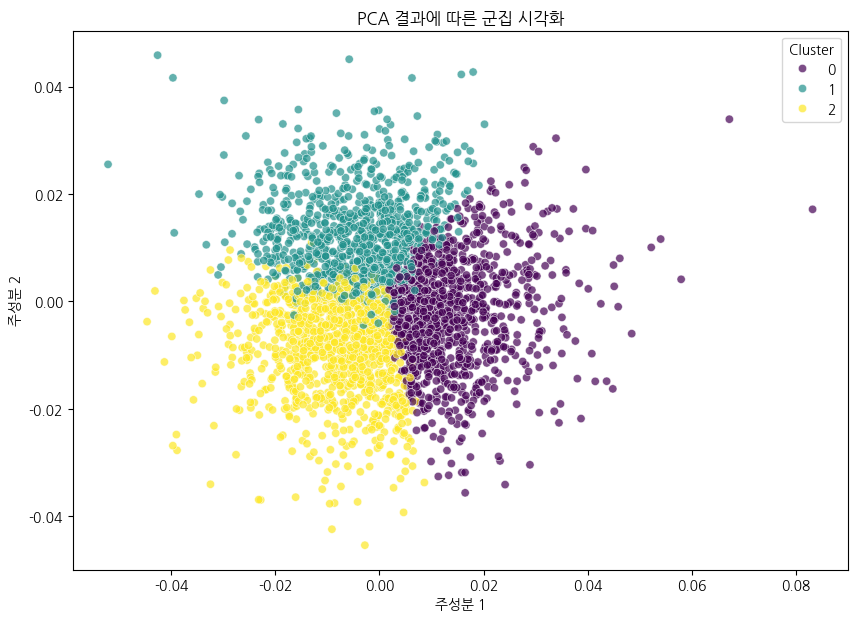

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# PCA를 사용하여 고차원 데이터를 2차원으로 축소
pca = PCA(n_components=2)
components = pca.fit_transform(pivot_df.drop(columns=['Cluster','idUser'], axis=1))

# PCA 결과와 군집 라벨을 DataFrame으로 변환
pca_df = pd.DataFrame(data=components, columns=['principal component 1', 'principal component 2'])
pca_df['Cluster'] = pivot_df['Cluster']

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=pca_df, palette='viridis', legend='full', alpha=0.7)
plt.title('PCA 결과에 따른 군집 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.legend(title='Cluster')
plt.show()

In [44]:
tmp=pivot_df[['idUser','Cluster']]
df_cluster=pd.merge(order_user_item,tmp,on='idUser',how='left')

## RFM열 추가
    - RFM 열 너무 많아서 추가하지 않음
    - RFM 분석 시 임시로 만들어서 사용

# CSV파일로 저장

In [46]:
df_cluster.to_csv("kurly.csv", index=False)

In [53]:
kurly = pd.read_csv('kurly.csv')
print(kurly.shape)
kurly.head()

(1018711, 30)


,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined,Weekday,WeekdayName,Cluster
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"2030s, 여성",4,Friday,0
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"2030s, 여성",4,Friday,0
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"2030s, 여성",4,Friday,0
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"2030s, 여성",4,Friday,0
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"2030s, 여성",4,Friday,0


# 모델링용 csv 파일 만들기
    - 일주일 후 매출액 예측

In [62]:
kurly['Date'] = pd.to_datetime(kurly['Date'])
kurly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018711 entries, 0 to 1018710
Data columns (total 30 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   idUser             1018711 non-null  object        
 1   idOrder            1018711 non-null  object        
 2   OrderDT            1018711 non-null  object        
 3   ItemCode           1018711 non-null  object        
 4   Price              1018711 non-null  int64         
 5   DeliveryDT         1018711 non-null  object        
 6   Delay_YN           1018711 non-null  int64         
 7   ItemLargeCode      1018711 non-null  object        
 8   ItemLargeName      1018711 non-null  object        
 9   ItemMiddleCode     1018711 non-null  object        
 10  ItemMiddleName     1018711 non-null  object        
 11  ItemSmallCode      1018711 non-null  object        
 12  ItemSmallName      1018711 non-null  object        
 13  ItemName           1018711 

In [63]:
date_range_df = pd.DataFrame({"Date": pd.date_range(start="2021-01-01", end="2023-12-31")})

# 결과 확인
date_range_df.head(), date_range_df.tail()

(        Date
 0 2021-01-01
 1 2021-01-02
 2 2021-01-03
 3 2021-01-04
 4 2021-01-05,
            Date
 1090 2023-12-27
 1091 2023-12-28
 1092 2023-12-29
 1093 2023-12-30
 1094 2023-12-31)

In [64]:
df1 = kurly.groupby(['Date','Gender'])['idOrder'].count()
df1 = df1.unstack()

In [65]:
df2 = kurly.groupby(['Date','AgeGroup'])['idOrder'].count()
df2 = df2.unstack()

In [66]:
df = pd.merge(date_range_df,df1, on='Date', how='left')
df = pd.merge(df, df2, on='Date', how='left')
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.weekday
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Weekday'] = df['Weekday'].map(weekday_map)
df['Sat_YN'] = df['Weekday']=='Saturday'
df

,Date,남성,여성,2030s,4060s,Weekday,Sat_YN
0,2021-01-01,679.0,865.0,1026.0,518.0,Friday,False
1,2021-01-02,NaN,NaN,NaN,NaN,Saturday,True
2,2021-01-03,8.0,31.0,20.0,19.0,Sunday,False
3,2021-01-04,808.0,1347.0,1445.0,710.0,Monday,False
4,2021-01-05,160.0,233.0,266.0,127.0,Tuesday,False
...,...,...,...,...,...,...,...
1090,2023-12-27,578.0,795.0,1038.0,335.0,Wednesday,False
1091,2023-12-28,554.0,855.0,938.0,471.0,Thursday,False
1092,2023-12-29,432.0,629.0,759.0,302.0,Friday,False
1093,2023-12-30,37.0,57.0,64.0,30.0,Saturday,True


In [67]:
df3 = kurly.groupby('Date')['Delay_YN'].mean().reset_index()

In [68]:
df = pd.merge(df, df3, on='Date', how='left')

,Date,남성,여성,2030s,4060s,Weekday,Sat_YN,Delay_YN
0,2021-01-01,679.0,865.0,1026.0,518.0,Friday,False,0.024611
1,2021-01-02,NaN,NaN,NaN,NaN,Saturday,True,NaN
2,2021-01-03,8.0,31.0,20.0,19.0,Sunday,False,0.000000
3,2021-01-04,808.0,1347.0,1445.0,710.0,Monday,False,0.038515
4,2021-01-05,160.0,233.0,266.0,127.0,Tuesday,False,0.025445
...,...,...,...,...,...,...,...,...
1090,2023-12-27,578.0,795.0,1038.0,335.0,Wednesday,False,0.040787
1091,2023-12-28,554.0,855.0,938.0,471.0,Thursday,False,0.026260
1092,2023-12-29,432.0,629.0,759.0,302.0,Friday,False,0.032045
1093,2023-12-30,37.0,57.0,64.0,30.0,Saturday,True,0.000000


In [69]:
df4 = kurly.groupby('Date')['Price'].sum().reset_index()
df = pd.merge(df, df4, on='Date', how='left')

In [70]:
df5 = kurly.groupby(['Date'])['Gender'].value_counts(normalize=True).unstack()
df5 = df5[['여성']]
df = pd.merge(df, df5, on = 'Date', how='left')

In [71]:
df6 = kurly.groupby(['Date'])['AgeGroup'].value_counts(normalize=True).unstack()
df6 = df6[['2030s']]
df = pd.merge(df, df6, on = 'Date', how='left')

In [73]:
df.columns = ['Date', '남성', '여성', '2030s', '4060s', 'Weekday', 'Sat_YN',
       'Delay_YN', 'Price', '여성 비율', '2030s 비율']
df

,Date,남성,여성,2030s,4060s,Weekday,Sat_YN,Delay_YN,Price,여성 비율,2030s 비율
0,2021-01-01,679.0,865.0,1026.0,518.0,Friday,False,0.024611,22887260.0,0.560233,0.664508
1,2021-01-02,NaN,NaN,NaN,NaN,Saturday,True,NaN,NaN,NaN,NaN
2,2021-01-03,8.0,31.0,20.0,19.0,Sunday,False,0.000000,660410.0,0.794872,0.512821
3,2021-01-04,808.0,1347.0,1445.0,710.0,Monday,False,0.038515,31532410.0,0.625058,0.670534
4,2021-01-05,160.0,233.0,266.0,127.0,Tuesday,False,0.025445,5682250.0,0.592875,0.676845
...,...,...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,578.0,795.0,1038.0,335.0,Wednesday,False,0.040787,22032270.0,0.579024,0.756009
1091,2023-12-28,554.0,855.0,938.0,471.0,Thursday,False,0.026260,22423860.0,0.606813,0.665720
1092,2023-12-29,432.0,629.0,759.0,302.0,Friday,False,0.032045,16659780.0,0.592837,0.715363
1093,2023-12-30,37.0,57.0,64.0,30.0,Saturday,True,0.000000,1479180.0,0.606383,0.680851


In [74]:
kurly['Gender'].value_counts(normalize=True)['여성']

0.6040113437471472

In [75]:
# 결측치 대체용 평균
male_21_wed_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Wednesday')]['남성'].mean()
male_21_sat_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Saturday')]['남성'].mean()
male_23_sat_mean = df[(df['Date']>='2023-1-1') & (df['Weekday']=='Saturday')]['남성'].mean()
female_21_wed_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Wednesday')]['여성'].mean()
female_21_sat_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Saturday')]['여성'].mean()

age_2030_wed_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Wednesday')]['2030s'].mean()
age_4060_wed_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Wednesday')]['4060s'].mean()
age_2030_sat_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Saturday')]['2030s'].mean()
age_4060_sat_mean = df[(df['Date']<='2021-12-31') & (df['Weekday']=='Saturday')]['4060s'].mean()
age_4060_sat_mean_2 = df[(df['Date']>='2021-12-31') & (df['Date']<='2022-12-31') & (df['Weekday']=='Saturday')]['4060s'].mean()

delay_mean = df['Delay_YN'].mean()

male_21_wed_mean = df[(df['Date']<='2021-12-31')& (df['Weekday']=='Wednesday')]['Price'].mean()
male_21_sat_mean = df[(df['Date']<='2021-12-31')& (df['Weekday']=='Saturday')]['Price'].mean()

ratio_female = kurly['Gender'].value_counts(normalize=True)['여성']
ratio_2030 = kurly['AgeGroup'].value_counts(normalize=True)['2030s']

In [76]:
# 결측치 대체
df.loc[(df['Date']<='2021-12-31')&(df['남성'].isnull())&(df['Weekday']=='Wednesday'), '남성'] = male_21_wed_mean
df.loc[(df['Date']<='2021-12-31')&(df['남성'].isnull())&(df['Weekday']=='Saturday'), '남성'] = male_21_sat_mean
df.loc[(df['Date']>='2023-1-1')&(df['남성'].isnull())&(df['Weekday']=='Saturday'), '남성'] = male_23_sat_mean
df.loc[(df['Date']<='2021-12-31')&(df['여성'].isnull())&(df['Weekday']=='Wednesday'), '여성'] = female_21_wed_mean
df.loc[(df['Date']<='2021-12-31')&(df['여성'].isnull())&(df['Weekday']=='Saturday'), '여성'] = female_21_sat_mean

df.loc[(df['Date']<='2021-12-31')&(df['2030s'].isnull())&(df['Weekday']=='Wednesday'), '2030s'] = age_2030_wed_mean
df.loc[(df['Date']<='2021-12-31')&(df['2030s'].isnull())&(df['Weekday']=='Saturday'), '2030s'] = age_2030_sat_mean
df.loc[(df['Date']<='2021-12-31')&(df['4060s'].isnull())&(df['Weekday']=='Wednesday'), '4060s'] = age_4060_wed_mean
df.loc[(df['Date']<='2021-12-31')&(df['4060s'].isnull())&(df['Weekday']=='Saturday'), '4060s'] = age_4060_sat_mean
df.loc[(df['Date']>='2021-12-31') & (df['Date']<='2022-12-31') &(df['4060s'].isnull())&(df['Weekday']=='Saturday'), '4060s'] = age_4060_sat_mean_2

df.loc[df['Delay_YN'].isnull(), 'Delay_YN'] = delay_mean

df.loc[(df['Date']<='2021-12-31')&(df['Price'].isnull())&(df['Weekday']=='Wednesday'), 'Price'] = male_21_wed_mean
df.loc[(df['Date']<='2021-12-31')&(df['Price'].isnull())&(df['Weekday']=='Saturday'), 'Price'] = male_21_sat_mean

df.loc[df['여성 비율'].isnull(), '여성 비율'] = ratio_female
df.loc[df['2030s 비율'].isnull(), '2030s 비율'] = ratio_female

df.isnull().sum()

Date        0
남성          0
여성          0
2030s       0
4060s       0
Weekday     0
Sat_YN      0
Delay_YN    0
Price       0
여성 비율       0
2030s 비율    0
dtype: int64

In [77]:
df_model = df.drop(['Weekday','Sat_YN'], axis=1)

,Date,남성,여성,2030s,4060s,Delay_YN,Price,여성 비율,2030s 비율
0,2021-01-01,679.000000,865.000000,1026.00000,518.0,0.024611,2.288726e+07,0.560233,0.664508
1,2021-01-02,623178.809524,27.108108,30.04878,16.0,0.037942,6.231788e+05,0.604011,0.604011
2,2021-01-03,8.000000,31.000000,20.00000,19.0,0.000000,6.604100e+05,0.794872,0.512821
3,2021-01-04,808.000000,1347.000000,1445.00000,710.0,0.038515,3.153241e+07,0.625058,0.670534
4,2021-01-05,160.000000,233.000000,266.00000,127.0,0.025445,5.682250e+06,0.592875,0.676845
...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,578.000000,795.000000,1038.00000,335.0,0.040787,2.203227e+07,0.579024,0.756009
1091,2023-12-28,554.000000,855.000000,938.00000,471.0,0.026260,2.242386e+07,0.606813,0.665720
1092,2023-12-29,432.000000,629.000000,759.00000,302.0,0.032045,1.665978e+07,0.592837,0.715363
1093,2023-12-30,37.000000,57.000000,64.00000,30.0,0.000000,1.479180e+06,0.606383,0.680851


In [78]:
df_model['target']=df_model['Price'].shift(-7)
df_model.tail(10)

,Date,남성,여성,2030s,4060s,Delay_YN,Price,여성 비율,2030s 비율,target
1085,2023-12-22,383.0,746.0,796.0,333.0,0.018601,17589470.0,0.660762,0.705049,16659780.0
1086,2023-12-23,38.0,32.0,47.0,23.0,0.000000,1163490.0,0.457143,0.671429,1479180.0
1087,2023-12-24,702.0,902.0,1184.0,420.0,0.023691,25785060.0,0.562344,0.738155,28730790.0
1088,2023-12-25,413.0,667.0,817.0,263.0,0.012963,17628330.0,0.617593,0.756481,NaN
1089,2023-12-26,600.0,881.0,979.0,502.0,0.015530,23492940.0,0.594868,0.661040,NaN
1090,2023-12-27,578.0,795.0,1038.0,335.0,0.040787,22032270.0,0.579024,0.756009,NaN
1091,2023-12-28,554.0,855.0,938.0,471.0,0.026260,22423860.0,0.606813,0.665720,NaN
1092,2023-12-29,432.0,629.0,759.0,302.0,0.032045,16659780.0,0.592837,0.715363,NaN
1093,2023-12-30,37.0,57.0,64.0,30.0,0.000000,1479180.0,0.606383,0.680851,NaN
1094,2023-12-31,788.0,1009.0,1375.0,422.0,0.037841,28730790.0,0.561491,0.765164,NaN


In [79]:
# 원본 Price 제거
df_model.drop('Price', axis=1, inplace=True)
df_model

,Date,남성,여성,2030s,4060s,Delay_YN,여성 비율,2030s 비율,target
0,2021-01-01,679.000000,865.000000,1026.00000,518.0,0.024611,0.560233,0.664508,1.829174e+07
1,2021-01-02,623178.809524,27.108108,30.04878,16.0,0.037942,0.604011,0.604011,6.231788e+05
2,2021-01-03,8.000000,31.000000,20.00000,19.0,0.000000,0.794872,0.512821,1.308180e+06
3,2021-01-04,808.000000,1347.000000,1445.00000,710.0,0.038515,0.625058,0.670534,2.877023e+07
4,2021-01-05,160.000000,233.000000,266.00000,127.0,0.025445,0.592875,0.676845,4.363620e+06
...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,578.000000,795.000000,1038.00000,335.0,0.040787,0.579024,0.756009,NaN
1091,2023-12-28,554.000000,855.000000,938.00000,471.0,0.026260,0.606813,0.665720,NaN
1092,2023-12-29,432.000000,629.000000,759.00000,302.0,0.032045,0.592837,0.715363,NaN
1093,2023-12-30,37.000000,57.000000,64.00000,30.0,0.000000,0.606383,0.680851,NaN


In [80]:
df_model.to_csv("df_model.csv",index=False)